<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Wage_and_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [398]:
# Install all dependencies
!pip install gensim
!pip install nltk
!pip install pandas
!pip install numpy
!pip install requests
!pip install playwright
!playwright install
!pip install pycountry

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libgtk-4.so.1                                    ║
║     libgraphene-1.0.so.0                             ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.11/dist-packages/playwright/driver/package/lib/serv

In [ ]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument,Word2Vec
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from termcolor import colored
import pandas as pd
import numpy as np
import requests
import re
import plotly.graph_objects as go
import nltk
nltk.download('all', download_dir='/usr/local/lib/nltk_data')
from nltk import pos_tag
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
import pycountry
import lightgbm as lgb

In [400]:
from google.colab import files

# Upload profile data
print("Please upload the profile_data file")
uploaded_profile = files.upload()
profile_data_file = next(iter(uploaded_profile.keys()))

# Upload job details
print("\nPlease upload the job_details file")
uploaded_job = files.upload()
job_details_file = next(iter(uploaded_job.keys()))

# Upload full model
print("\nPlease upload the full_model.pkl file")
uploaded_full_model = files.upload()
full_model_file = next(iter(uploaded_full_model.keys()))


Please upload the profile_data file


Saving profile_data (6).txt to profile_data (6) (1).txt

Please upload the job_details file


Saving job_details (6).txt to job_details (6).txt

Please upload the full_model.pkl file


Saving full_model.pkl to full_model (2).pkl


In [401]:
def extract_section(file_path, start_keyword, end_keyword):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    extracting = False
    extracted_text = []

    for line in lines:
        if start_keyword in line:
            extracting = True
        if extracting:
            extracted_text.append(line.strip())
        if end_keyword in line:
            break

    return "\n".join(extracted_text)

unique_skills_raw = extract_section(profile_data_file, "Unique skills:", "Unique skills:")

if unique_skills_raw.startswith("Unique skills:"):
    unique_skills = unique_skills_raw.replace("Unique skills:", "").strip()

# Convert skills to a formatted string
profile_skills = f"""['{unique_skills.replace(', ', "', '")}']"""



In [402]:
print(profile_skills)

['Apache Spark', 'Data Analysis', 'Data Structures', 'Deep Learning', 'Django', 'HTML', 'Java', 'PyTorch', 'Python (Programming Language)', 'SQL', 'Statistical Data Analysis']


In [403]:
def extract_description(file_path, start_keyword, end_keyword=None):
    """
    Extract a specific section of text from a file based on start and optional end keywords.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    extracting = False
    extracted_text = []

    for line in lines:
        if start_keyword in line:
            extracting = True
        if extracting:
            extracted_text.append(line.rstrip())  # Keep formatting with spaces
        if end_keyword and end_keyword in line:
            break

    return "\n".join(extracted_text)


# Extract the description section
job_description = extract_description(job_details_file, "Description  :")



In [404]:
print(job_description)

Description  : LSports is the leading global provider of sports data, dedicated to revolutionizing the industry through innovative solutions. We excel in sports data collection and analysis, advanced data management, and cutting-edge services like AI-based sports tips and high-quality sports visualization. As the sports data industry continues to grow, LSports remains at the forefront, delivering real-time solutions.

If you share our passion for sports and technology and have the drive to advance the sports-tech and data industries, we invite you to join our team!




If you share our love of sports and tech, you've got the passion and will to better the sports-tech and data industries - join the team! We are looking for a highly motivated Data Engineer.




About the team: Data Integrity

LSports Data Integrity is one of the main pillars of the company's offering and long-term strategy.

We are pushing the boundaries of real-time analysis, utilizing machine learning and artificial in

In [405]:


# Extended stopwords for job descriptions
stop_words = set(stopwords.words('english')).union({
    'have', 'has', 'you', 'we', 'they', 'our', 'your', 'the', 'a', 'an', 'in', 'on', 'at', 'for', 'with', 'to', 'of',
    'and', 'or', 'is', 'are', 'was', 'were', 'be', 'will', 'can', 'should', 'would', 'could', 'may', 'might',
    'solid', 'relevant', 'extensive', 'proven', 'experience', 'possess', 'ability', 'skills', 'capabilities',
    'demonstrated', 'strong', 'knowledge', 'understanding', 'background', 'proficiency', 'required',
    'responsibilities', 'qualifications', 'advantage', 'must', 'preferred', 'environment', 'excellent', 'good',
    'key', 'various', 'well', 'including', 'new', 'opportunities', 'job', 'role', 'position', 'description', 'youve',
    'passion', 'requirements', 'cuttingedge','highquality'
})

def preprocess_text(text):
    """
    Preprocess text by removing excessive newlines, extra spaces, and replacing special characters appropriately.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    text = re.sub(r'\s*\n\s*', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'/', ' ', text)          # Replace slash with a space
    text = re.sub(r'\s+', ' ', text)         # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)      # Remove other special characters
    return text.strip().lower()             # Lowercase and strip whitespace


def extract_relevant_phrases(sentence):
    """
    Extract relevant phrases from a sentence by removing unnecessary words and focusing on key phrases.
    """
    # Remove unnecessary phrases using regex
    cleaned_sentence = re.sub(r'\b(have|has|possess|proven|solid|relevant|extensive|demonstrated|strong)\b', '', sentence, flags=re.IGNORECASE)
    cleaned_sentence = re.sub(r'\b(experience (in|with|on|of|for))\b', '', cleaned_sentence, flags=re.IGNORECASE)
    cleaned_sentence = re.sub(r'\b(ability to|proficiency in|knowledge of|understanding of|background in)\b', '', cleaned_sentence, flags=re.IGNORECASE)

    # Tokenize and remove stopwords
    tokens = word_tokenize(cleaned_sentence.lower())
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    # Extract nouns using POS tagging
    pos_tags = pos_tag(tokens)
    relevant_phrases = [word for word, tag in pos_tags if tag.startswith('NN')]  # Keep only nouns

    # Remove duplicate words while preserving order
    unique_words = []
    for word in relevant_phrases:
        if word not in unique_words:
            unique_words.append(word)

    return ' '.join(unique_words)

def process_job_description(description):
    """
    Process job description to split into sentences and extract relevant parts,
    ensuring that the resulting phrases have no more than 3 words.
    """
    # Split the description into sentences using punctuation or bullet points
    sentences = re.split(r'[.\n•;]', description)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]  # Remove empty strings

    processed_sentences = []
    for sentence in sentences:
        # Split sentences longer than a threshold into smaller parts by words
        if len(sentence.split()) > 3:
            # Using a flexible regex to split by commas, "and", or "or"
            chunks = re.split(r'(?:,\s*|\s+and\s+|\s+or\s+)', sentence, flags=re.IGNORECASE)
            processed_sentences.extend([chunk.strip() for chunk in chunks if chunk.strip()])
        else:
            processed_sentences.append(sentence.strip())

    # Extract relevant phrases from each chunk
    processed_chunks = [extract_relevant_phrases(preprocess_text(chunk)) for chunk in processed_sentences]
    processed_chunks = [chunk for chunk in processed_chunks if chunk]  # Remove empty results

    # --- Additional Step: Ensure each phrase is no longer than 3 words ---
    final_chunks = []
    for phrase in processed_chunks:
        words = phrase.split()
        if len(words) > 3:
            # Split the phrase into subphrases with at most 3 words each
            for i in range(0, len(words), 3):
                subphrase = " ".join(words[i:i+3])
                final_chunks.append(subphrase)
        else:
            final_chunks.append(phrase)

    return final_chunks


# 2. Main Workflow
def compute_similarity(job_description, profile_skills, model, threshold=0.7):
    """
    Compute similarity between job description and profile skills using embeddings.
    """
    # Preprocess inputs
    job_skills_processed = process_job_description(preprocess_text(job_description))
    profile_skills_list = [preprocess_text(skill) for skill in eval(profile_skills)]  # Convert and preprocess profile skills

    # Encode skills using Sentence-BERT
    job_embeddings = model.encode(job_skills_processed, convert_to_tensor=True)
    profile_embeddings = model.encode(profile_skills_list, convert_to_tensor=True)

    # Compute cosine similarities
    cosine_similarities = util.pytorch_cos_sim(job_embeddings, profile_embeddings)

    # Adjust similarities based on threshold
    adjusted_similarities = []
    improvement_list=[]
    improvement_score=0.5
    total_similarity = 0
    comparison_count = 0

    for i in range(len(job_skills_processed)):
        similarity_row = cosine_similarities[i].tolist()
        max_similarity = max(similarity_row)
        # if max_similarity > threshold:
        #     similarity_row = [1.0] * len(similarity_row)
        if max_similarity <= improvement_score:
            improvement_list.append(job_skills_processed[i])
        adjusted_similarities.append(similarity_row)
        total_similarity += sum(similarity_row)
        comparison_count += len(similarity_row)

    # Calculate overall similarity
    overall_similarity = min(total_similarity / comparison_count , 1.0) if comparison_count > 0 else 0

    return adjusted_similarities, overall_similarity, job_skills_processed, profile_skills_list, improvement_list


In [406]:

#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('bert-base-nli-mean-tokens')
#model = SentenceTransformer('all-roberta-large-v1')



# Compute similarities
adjusted_similarities, overall_similarity, job_skills_processed, profile_skills_processed,improvement_list = compute_similarity(
    job_description, profile_skills, model
)

# Display results
print("Adjusted Similarities:")
for i, job_skill in enumerate(job_skills_processed):
    for j, profile_skill in enumerate(profile_skills_processed):
        similarity_score = adjusted_similarities[i][j]
        print(f"Similarity between job skill '{job_skill}' and profile skill '{profile_skill}': {similarity_score:.2f}")



Adjusted Similarities:
Similarity between job skill 'lsports provider sports' and profile skill 'apache spark': 0.45
Similarity between job skill 'lsports provider sports' and profile skill 'data analysis': 0.56
Similarity between job skill 'lsports provider sports' and profile skill 'data structures': 0.50
Similarity between job skill 'lsports provider sports' and profile skill 'deep learning': 0.46
Similarity between job skill 'lsports provider sports' and profile skill 'django': 0.34
Similarity between job skill 'lsports provider sports' and profile skill 'html': 0.45
Similarity between job skill 'lsports provider sports' and profile skill 'java': 0.39
Similarity between job skill 'lsports provider sports' and profile skill 'pytorch': 0.50
Similarity between job skill 'lsports provider sports' and profile skill 'python programming language': 0.25
Similarity between job skill 'lsports provider sports' and profile skill 'sql': 0.27
Similarity between job skill 'lsports provider sports

In [407]:
print(f"\nOverall Similarity: {overall_similarity:.2f}")


Overall Similarity: 0.50


In [408]:
# Assume similarity is your final score as a percentage
similarity = overall_similarity * 100  # Convert to percentage if in range [0, 1]


In [409]:

# Visualization
fig = go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=similarity,
    mode="gauge+number",
    title={'text': "Matching percentage (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 50], 'color': "#FFB6C1"},  # Light pink for low match
            {'range': [50, 70], 'color': "#FFFFE0"},  # Light yellow for moderate match
            {'range': [70, 100], 'color': "#90EE90"}  # Light green for high match
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': similarity}  # Mark the current similarity
    }
))

fig.update_layout(width=600, height=400)  # Adjust the width and height as desired
fig.show()
print("Skills you might want to improve to increase your odds of getting the job:")
print(improvement_list)


Skills you might want to improve to increase your odds of getting the job:
['services sports tips', 'drive advance sportstech', 'sportstech']


In [410]:
import joblib
# loading model

full_model_dict = joblib.load(full_model_file)

# data extraction

quantile_models = full_model_dict["quantile_models"]
salary_spline = full_model_dict["salary_spline"]
train_columns = full_model_dict["train_columns"]
y_train = full_model_dict["y_train"]
predicted_salaries_train = full_model_dict["y_pred_train"]
y_test = full_model_dict["y_test"]
predicted_salaries_test = full_model_dict["y_pred_test"]
residual_errors_train = full_model_dict["residual_errors_train"]
quantile_predictions_train = full_model_dict["train_preds"]
quantile_predictions_test = full_model_dict["test_preds"]

print("All models and training results loaded successfully from 'full_model.pkl'.")

X_train_encoded = pd.DataFrame(columns=train_columns)  #


All models and training results loaded successfully from 'full_model.pkl'.


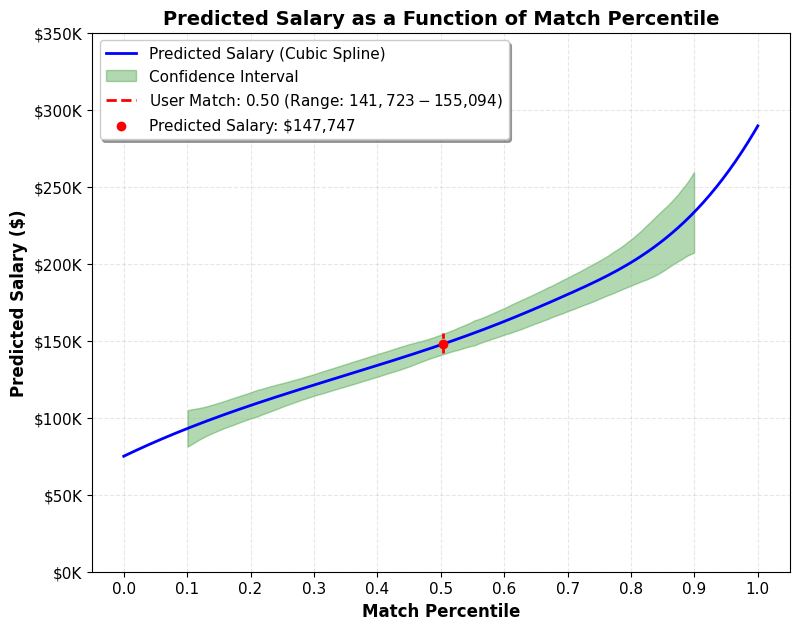

In [411]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Define the range of match percentiles
match_percentiles = np.linspace(0, 1, 200)

# 🔹 Predict salary for each percentile using the trained Spline model
predicted_salaries = salary_spline(match_percentiles)

# 🔹 Compute the user's match percentile and predicted salary
user_match_percentile = overall_similarity  # Dynamic value
predicted_salary = salary_spline(user_match_percentile)

# 🔹 Compute local standard deviation based on residual percentiles
sigma_percentiles = np.array([
    np.std(residual_errors_train[
        (residual_errors_train >= np.percentile(residual_errors_train, p * 100 - 5)) &
        (residual_errors_train <= np.percentile(residual_errors_train, p * 100 + 5))
    ]) if 5 < p * 100 < 95 else np.std(residual_errors_train)  # Handling edge cases
    for p in match_percentiles
])

# 🔹 Define the 95% confidence interval
salary_lower_bound = predicted_salaries - 1.96 * sigma_percentiles
salary_upper_bound = predicted_salaries + 1.96 * sigma_percentiles

# 🔹 Set the green confidence interval range based on the user's match percentile
if user_match_percentile > 0.8:
    lower_limit = 0.1
    upper_limit = min(user_match_percentile + 0.1, 1)
elif user_match_percentile < 0.2:
    lower_limit = max(user_match_percentile - 0.1, 0)
    upper_limit = 0.9
else:
    lower_limit = 0.1
    upper_limit = 0.9

valid_range = (match_percentiles >= lower_limit) & (match_percentiles <= upper_limit)

# 🔹 Compute a dynamic upper limit for the Y-axis
salary_max_dynamic = max(max(salary_upper_bound[valid_range]), max(predicted_salaries[valid_range])) + 50000

# 🔹 Create the plot
plt.figure(figsize=(9, 7))

# 🔹 Plot the predicted salary curve
plt.plot(match_percentiles, predicted_salaries, label="Predicted Salary (Cubic Spline)", color="blue", linewidth=2)

# 🔹 Plot the confidence interval only in relevant areas
plt.fill_between(match_percentiles[valid_range],
                 salary_lower_bound[valid_range],
                 salary_upper_bound[valid_range],
                 color="green", alpha=0.3, label="Confidence Interval")

# 🔹 Cut the red dashed line at the prediction range
user_idx = np.argmax(match_percentiles >= user_match_percentile)
plt.plot([user_match_percentile, user_match_percentile],
         [salary_lower_bound[user_idx], salary_upper_bound[user_idx]],
         color="red", linestyle="--", linewidth=2,
         label=f"User Match: {user_match_percentile:.2f} (Range: ${salary_lower_bound[user_idx]:,.0f} - ${salary_upper_bound[user_idx]:,.0f})")

# 🔹 Mark the user's predicted salary with a red dot
plt.scatter([user_match_percentile], [predicted_salary], color="red", zorder=3,
            label=f"Predicted Salary: ${predicted_salary:,.0f}")

# 🔹 Set X-axis ticks at 0.1 intervals
plt.xticks(np.arange(0, 1.1, 0.1), [f"{x:.1f}" for x in np.arange(0, 1.1, 0.1)], fontsize=11)

# 🔹 Set a dynamic Y-axis range
salary_min = 0
yticks = np.arange(salary_min, salary_max_dynamic + 50000, 50000)
plt.yticks(yticks, [f"${int(y/1000)}K" for y in yticks], fontsize=11)

# 🔹 Customize the plot
plt.xlabel("Match Percentile", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Salary ($)", fontsize=12, fontweight="bold")
plt.title("Predicted Salary as a Function of Match Percentile", fontsize=14, fontweight="bold")
plt.legend(fontsize=11, loc="upper left", frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle="--")

# 🔹 Display the plot
plt.show()
